In [22]:
import sys
import os
# go to upper diretory
import csv
import glob
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier as RandomForest, RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
sys.path.append(os.path.abspath('./../../../'))
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = 'extracted_features_iemocap.csv'
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
config = Configuration.load_json(CONFIG_FILE)

## Extracting the 24 features selected from the eNTERFACE05 dataset study

In [3]:
chosen_features = {'var_mfcc15', 'min_mfcc17', 'std_chroma_stft', 'mean_zcr',
    'min_zcr', 'var_mfcc4', 'spikes_spec_cent', 'var_spec_bw', 'max_mfcc6',
    'min_mfcc19', 'max_mfcc13', 'max_mfcc5', 'var_mfcc9', 'min_mfcc7', 'var_mfcc1',
    'max_mfcc1', 'max_mfcc9', 'var_mel_spect', 'mean_spec_cont', 'var_mfcc2', 'max_mfcc10',
    'min_spec_cent', 'var_mfcc14', 'var_mfcc3'}

In [4]:
headers = [
    'File', 'Interaction', 'Gender', 'Duration', 'Emotion', 'Emotion_Id',
    'Valence', 'Activation', 'Dominance',
    'std_chroma_stft', 'mean_zcr', 'min_zcr',
    'var_mel_spect', 'spikes_spec_cent', 'min_spec_cent',
    'var_spec_bw', 'mean_spec_cont', 
    'var_mfcc1', 'max_mfcc1', 'var_mfcc2', 'var_mfcc3', 'var_mfcc4',
    'max_mfcc5', 'max_mfcc6', 'min_mfcc7', 'var_mfcc9', 'max_mfcc9',
    'max_mfcc10', 'max_mfcc13', 'var_mfcc14', 'var_mfcc15', 
    'min_mfcc17', 'min_mfcc19'
]

In [5]:
def spikes(data):
    if len(data.shape) != 1:
        data = np.concatenate(data)
    mean = np.mean(data)
    std = np.std(data)
    threshold = mean + std * 2 / 100
    num_spikes = 0
    for value in data:
        if value >= threshold:
            num_spikes += 1

    return num_spikes

In [6]:
emotion_label = {
    'ang': "angry",
    'hap': "happy",
    'sad': "sad",
    'neu': "neutral",
    'fru': "frustrated",
    'exc': "excited",
    'fea': "fearful",
    'sur': "surprised",
    'dis': "disgusted",
    'xxx': "other",
    'oth': "other"
}

emotion_number = {
    'ang': 0,
    'hap': 1,
    'sad': 2,
    'neu': 3,
    'fru': 4,
    'exc': 5,
    'fea': 6,
    'sur': 7,
    'dis': 8,
    'oth': 9,
    'xxx': 9,
}

In [67]:
def extract_features(audio_file, duration, emotion, valence, activation, dominance, writer):
    file = audio_file.split(".")[-2].split("/")[-1]
    acting = "improvised" if file.split("_")[1][:5] == "impro" else "scripted"
    gender = "Male" if file.split("_")[-1][0] == 'M' else "Female"

    y, sr = librosa.load(audio_file, res_type='kaiser_fast')

    std_chroma_stft = np.std(librosa.feature.chroma_stft(y=y, sr=sr))
    zcr = librosa.feature.zero_crossing_rate(y=y)
    mean_zcr = np.mean(zcr)
    min_zcr = np.min(zcr)
    var_mel_spect = np.var(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=config.n_mels))
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spikes_spec_cent = spikes(spec_cent)
    min_spec_cent = np.min(spec_cent)
    var_spec_bw = np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    mean_spec_cont = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    var_mfcc1 = np.var(mfcc[0])
    max_mfcc1 = np.max(mfcc[0])
    var_mfcc2 = np.var(mfcc[1])
    var_mfcc3 = np.var(mfcc[2])
    var_mfcc4 = np.var(mfcc[3])
    max_mfcc5 = np.max(mfcc[4])
    max_mfcc6 = np.max(mfcc[5])
    min_mfcc7 = np.min(mfcc[6])
    var_mfcc9 = np.var(mfcc[8])
    max_mfcc9 = np.max(mfcc[8])
    max_mfcc10 = np.max(mfcc[9])
    max_mfcc13 = np.max(mfcc[12])
    var_mfcc14 = np.var(mfcc[13])
    var_mfcc15 = np.var(mfcc[14])
    min_mfcc17 = np.min(mfcc[16])
    min_mfcc19 = np.min(mfcc[18])

    features_str = f'{file} {acting} {gender} {duration} {emotion_label[emotion]} {emotion_number[emotion]}\
        {valence} {activation} {dominance}\
        {std_chroma_stft} {mean_zcr} {min_zcr} {var_mel_spect} {spikes_spec_cent} {min_spec_cent}\
        {var_spec_bw} {mean_spec_cont} {var_mfcc1} {max_mfcc1} {var_mfcc2} {var_mfcc3} {var_mfcc4}\
        {max_mfcc5} {max_mfcc6} {min_mfcc7} {var_mfcc9} {max_mfcc9} {max_mfcc10} {max_mfcc13}\
        {var_mfcc14} {var_mfcc15} {min_mfcc17} {min_mfcc19}'

    writer.writerow(features_str.split())

In [59]:
def process_data(audio_dir, headers, proc_feat_dataset):
    # Create a CSV for storing all processed features and write the header
    file = open(proc_feat_dataset, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(headers)

    print("Processing audio files from all dialogs:")
    for file_path in tqdm(glob.glob(audio_dir+'/Session[0-9]*/dialog/EmoEvaluation/*.txt')):
        emoEvalFile = open(file_path)

        for line in emoEvalFile:
            if line[0] == '[':
                args = line.split()
                duration = float(args[2][:-1]) - float(args[0][1:])
                # on windows
                audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/'+file_path.split("\\")[-1][:-4]+f'/{args[3]}.wav'
                # on linux/macOS
                # audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/{file_path.split("/")[-1][:-4]}/{args[3]}.wav'
                extract_features(audio_file, duration, args[4], args[5][1:-1], args[6][:-1], args[7][:-1], writer)

In [148]:
process_data(AUDIO_DIR, headers, EXTRACTED_FEATURES_FILE)

Processing audio files from all dialogs:


100%|██████████| 151/151 [09:47<00:00,  3.89s/it]


In [3]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df

Number of Audio Files: 10039


,Interaction,Gender,Duration,Emotion,Emotion_Id,Valence,Activation,Dominance,std_chroma_stft,mean_zcr,...,max_mfcc6,min_mfcc7,var_mfcc9,max_mfcc9,max_mfcc10,max_mfcc13,var_mfcc14,var_mfcc15,min_mfcc17,min_mfcc19
File,,,,,,,,,,,,,,,,,,,,,
Ses01F_impro01_F012,improvised,Female,2.750,angry,0,2.0,3.5,3.5,0.296270,0.082856,...,39.327560,-40.651329,42.375973,19.492970,19.512123,18.821735,47.666279,51.472340,-18.892769,-27.943581
Ses01F_impro04_F028,improvised,Female,2.010,angry,0,2.0,3.5,3.5,0.319851,0.086560,...,62.818893,-40.228039,84.092949,24.274593,11.059961,36.497154,29.247034,61.287384,-17.456673,-15.254041
Ses01F_impro04_F029,improvised,Female,3.160,angry,0,1.5,4.0,4.0,0.298296,0.085880,...,29.858166,-33.455795,164.847565,34.833263,22.882631,33.635147,118.356186,128.460770,-32.842518,-12.516586
Ses01F_impro04_F030,improvised,Female,3.185,angry,0,1.5,3.5,4.0,0.316109,0.106300,...,48.537384,-38.774422,178.178299,24.138340,11.319570,35.046803,183.465393,119.128494,-13.127378,-24.713459
Ses01F_impro04_F031,improvised,Female,4.400,angry,0,1.5,3.0,3.5,0.314387,0.065918,...,44.125771,-49.090309,100.364433,35.686844,29.594337,11.990172,68.253944,51.992161,-20.573139,-20.019981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ses05M_script03_2_M013,scripted,Male,9.340,other,10,2.0,3.5,4.0,0.314951,0.063627,...,58.600712,-46.007534,113.818436,32.636822,28.463696,25.335880,78.160225,66.925186,-27.014687,-21.044426
Ses05M_script03_2_M014,scripted,Male,4.150,other,10,1.5,3.5,4.0,0.315053,0.067145,...,73.493271,-54.896301,162.575638,31.630028,12.225033,33.560890,87.977707,42.288971,-24.003210,-19.897762
Ses05M_script03_2_M018,scripted,Male,2.170,other,10,3.5,3.0,3.0,0.302163,0.062219,...,51.708046,-34.321487,181.688660,23.869041,14.644627,14.957552,41.870499,43.103497,-20.033688,-19.955128


In [169]:
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
disgusted,8,2
excited,5,1041
fearful,6,40
frustrated,4,1849
happy,1,595
neutral,3,1708
other,9,3


In [151]:
df.groupby(['Gender']).agg({'Gender': ['count']})

,Gender
,count
Gender,
Female,4800
Male,5239


In [152]:
df.groupby(['Interaction']).agg({'Interaction': ['count']})

,Interaction
,count
Interaction,
improvised,4784
scripted,5255


In [153]:
df[["Duration"]].mean()

Duration    4.460109
dtype: float64

In [154]:
df[["Duration"]].min()

Duration    0.585
dtype: float64

## Data used in SOA models

In [4]:
df_soa = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df_soa.loc[df_soa['Emotion'] == 'excited', 'Emotion'] = 'happy'
df_soa.loc[df_soa['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df_soa.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


In [5]:
df_soa_improvised = df_soa[df_soa['Interaction'] == 'improvised']
df_soa_improvised.groupby(['Emotion']).agg({'Emotion': ['count']})

,Emotion
,count
Emotion,
angry,289
happy,947
neutral,1099
sad,608


### TODO: STUDY THE TIME DURATION THRESHOLD

In [172]:
df_soa_duration = df_soa[df_soa['Duration'] >= 2.5]
df_soa_duration.groupby(['Emotion']).agg({'Emotion': ['count']})

,Emotion
,count
Emotion,
angry,813
happy,1170
neutral,1105
sad,843


## Models

In [5]:
data = df_soa.iloc[:,8:]
regression_labels = df_soa.iloc[:,5:8].values
categorical_labels = np.ravel(df_soa.iloc[:,4:5].values)

In [6]:
def plot_cm_predictions(model, input_data, labels, cv=5, draw_corr_matrix=True, verbose=1, n_jobs=4):
    y_pred = cross_val_predict(model, input_data, labels, cv=cv, verbose=verbose, n_jobs=n_jobs)

    print("accuracy: ", metrics.accuracy_score(labels, y_pred))
    print("f1 score macro: ", metrics.f1_score(labels, y_pred, average='macro') )
    print("f1 score micro: ", metrics.f1_score(labels, y_pred, average='micro') )
    print("precision score: ", metrics.precision_score(labels, y_pred, average='macro') )
    print("recall score: ", metrics.recall_score(labels, y_pred, average='macro') )
    print("hamming loss: ", metrics.hamming_loss(labels, y_pred))
    print("matthews corrcoef: ", metrics.matthews_corrcoef(labels, y_pred) )
    print("zero one loss: ", metrics.zero_one_loss(labels, y_pred))
    print("mean absolute error: ", metrics.mean_absolute_error(labels, y_pred))

    print(metrics.classification_report(labels, y_pred))

    if draw_corr_matrix:
        cm = metrics.confusion_matrix(labels, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion Matrix Predicted Labels")
        plt.xlabel("Emotions Labels")
        plt.ylabel("Emotions Labels")
        plt.yticks(rotation=0)
        plt.show()

In [23]:
def build_model_0(input_shape=(24, 1), loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=1e-5, epsilon=1e-6)):
    if loss.__class__ == SparseCategoricalCrossentropy().__class__:
        n_labels = 4
        metrics = ['accuracy']
    else:
        n_labels = 3
        metrics = ['mean_absolute_error']

    model = Sequential()
    model.add(Conv1D(256, (5), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(n_labels, strides=1))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(n_labels))

    model.add(Activation('softmax'))

    model.add(Dense(n_labels))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [24]:
build_model_0(input_shape=(data.iloc[0].shape[0],1)).summary(show_trainable=True)

Model: "sequential_16"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d_48 (Conv1D)          (None, 20, 256)           1536      Y          
                                                                            
 batch_normalization_32 (Bat  (None, 20, 256)          1024      Y          
 chNormalization)                                                           
                                                                            
 activation_64 (Activation)  (None, 20, 256)           0         Y          
                                                                            
 conv1d_49 (Conv1D)          (None, 16, 128)           163968    Y          
                                                                            
 activation_65 (Activation)  (None, 16, 128)           0         Y          
                                                     

## Classification Problem (Emotion Categorical Label)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.1s finished


accuracy:  0.4952088229976496
f1 score macro:  0.5128402898669654
f1 score micro:  0.4952088229976496
precision score:  0.5235160408175284
recall score:  0.5050289689027115
hamming loss:  0.5047911770023504
matthews corrcoef:  0.31341736401352394
zero one loss:  0.5047911770023503
mean absolute error:  0.7868378231784487
              precision    recall  f1-score   support

           0       0.64      0.54      0.58      1103
           1       0.41      0.45      0.42      1636
           2       0.60      0.57      0.58      1084
           3       0.45      0.47      0.46      1708

    accuracy                           0.50      5531
   macro avg       0.52      0.51      0.51      5531
weighted avg       0.50      0.50      0.50      5531



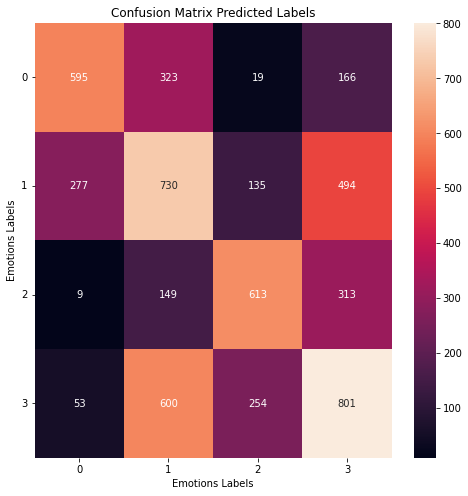

In [9]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data.values, categorical_labels)

In [25]:
callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 50
batch_size = 50
loss = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=1e-5, epsilon=1e-6)
verbosity = 0
num_folds = 5
acc_per_fold = []
loss_per_fold = []
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 2)

print('------------------------------------------------------------------------')

fold_no = 1
for train, test in kfold.split(df_soa):
  model = build_model_0(input_shape=(data.shape[1], 1), loss=loss, optimizer=optimizer)
  train_df = df_soa.iloc[train]
  x_train = train_df.iloc[:,8:].values
  y_train = np.ravel(train_df.iloc[:,4:5].values)
  
  test_df = df_soa.iloc[test]
  x_test = test_df.iloc[:,8:].values
  y_test = np.ravel(test_df.iloc[:,4:5].values)

  print(f'Training for fold {fold_no} ...')

  history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              workers=8)

  scores = model.evaluate(x_test,y_test, verbose=verbosity)

  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.386294960975647; accuracy of 17.615176737308502%
Training for fold 2 ...
Score for fold 2: loss of 1.386294960975647; accuracy of 28.57142984867096%
Training for fold 3 ...
Score for fold 3: loss of 1.386294960975647; accuracy of 20.976491272449493%
Training for fold 4 ...
Score for fold 4: loss of 4.692236423492432; accuracy of 36.70886158943176%
Training for fold 5 ...
Score for fold 5: loss of 1.5015838146209717; accuracy of 35.98553240299225%
------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 1.386294960975647 - Accuracy: 17.615176737308502%
> Fold 2 - Loss: 1.386294960975647 - Accuracy: 28.57142984867096%
> Fold 3 - Loss: 1.386294960975647 - Accuracy: 20.976491272449493%
> Fold 4 - Loss: 4.692236423492432 - Accuracy: 36.70886158943176%
> Fold 5 - Loss: 1.5015838146209717 - Accuracy: 35.98553240299225%
---

## Regression Problem (Valence, Activation, Dominance)

In [177]:
model = RandomForestRegressor(random_state=1, max_features=None)
pred_values = cross_val_predict(model, data.values, regression_labels, cv=5, verbose=1, n_jobs=8)
print('MAE: %.3f' % metrics.mean_absolute_error(pred_values, regression_labels))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


MAE: 0.663


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   10.0s finished


In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = KerasRegressor(build_fn=build_model_0, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])
# evaluate the model and collect the scores
mae_scores = cross_val_score(model, data.values, regression_labels, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=8)
# force the scores to be positive
mae_scores = np.absolute(mae_scores)
# summarize performance
print('MAE: %.3f +- %.3f' % (np.mean(mae_scores), np.std(mae_scores)))

C:\Users\Chico\AppData\Local\Temp\ipykernel_7744\3878304845.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model_0, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


MAE: 2.821 +- 0.025


[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    5.7s finished
